# MaskGIT: Masked Generative Image Transformer
- Authors: Huiwen Chang, Han Zhang, Lu Jiang, Ce Liu, William T. Freeman
- Paper link: __[Arxiv](https://arxiv.org/abs/2202.04200)__
- Conference: CVPR2022

## Project Group 04
- Ardan Yılmaz, 2172195: yilmaz.ardan@metu.edu.tr
- Şahin Umutcan Üstündaş, 2099703: umutcan.ustundas@metu.edu.tr

## Paper Summary

In this paper, the authors propose a novel masking method and a bidirectional transformer decoder, named MaskGIT. The model learns to predict randomly masked tokens by attending to tokens in all directions. Then, during inference, the model generates all of the tokens simultaneously in an iterative manner. In this way, the model decodes every pixel simultaneously, which speeds up the generation process by up to 64x, as claimed by the paper.

The proposed framework has two stages:
1) First, a tokenizer tokenizes the image into visual tokens.
2) Second, the tokens are masked with a masking scheme and a bidirectional transformer predicts the masked tokens (Masked Visual Token Modeling - MVTM)

After learning a how to predict tokens by attending to others in all directions, for inference, an iterative decoding process is employed.


Within the scope of the paper, the authors used the same setup for the first stage as it is done in VQGAN model, and focused on MVTM.

## Model Overview

![Overview](figures/Overview.png)

(Chang et al., 2022)

## Model Architecture

We used a similar method described in the paper for implementation.

- We used a pretrained VQGAN encoder from "Taming Transformers for High-Resolution Image Synthesis" (Esser et al., 2021). for extracting visual tokens.
- We implemented the MVTM method described in MaskGIT paper.

### VQGAN Overview
Generates images in the latent space in two stages:
1. Tokenization: Compress the image in the latent space. It has three key components:
    - Encoder $E$: learns to tokenize the images $x \in \mathbb{R}^{HxWx3}$ into latent embedding $E(x)$
    - A codebook, $e_k \in \mathbb{R}^D$, $k \in 1,2,...,K$, is a nearest neighbor look-up to quantize the embeddings to visual tokens.
    - A decoder $G$ reconstructs the image
2. After learning to tokenize, upon interpretation, it first tokenizes the image into latent priors, then decodes it to image pixels.


### MVTM Overview

Employing the BERT idea from the NLP domain, MVTM masks a part of an image first then uses bidirectional transformer to predict the masked tokens by attending to all tokens in any directions, which makes it different and more powerful than autoregressive models, and accounts for more robust representation learning.


1. **MVTM Training**
- For a batch of images, corresponding latent tokens are retrieved from the pre-trained VQGAN model. 
    - N: length of the token matrix
    - $Y = [y_i]_{i=1}^N$: latent tokens obtained    
- Sample a subset of tokens to mask
    - $M = [m_i]_{i=1}^N$: binary matrix
    - Replace the visual token $y_i$ with a special [MASK] token if $m_i == 1$, leave it as is otherwise.
- Sampling procedure:
    - Use a parametrized mask scheduling function: $\gamma(r) \in (0, 1]$
    - $r$: Ratio sampled randomly from $(0, 1]$
    - $n$: number of tokens to mask. $n = \lfloor \gamma(r)*N \rfloor $
- Loss function: Dealing with discrete variables, cross-entropy between ground-truth and predicted tokens is used as the loss function.
    - $L_{mask} = -\mathbb{E}_{Y \in D} [\sum_{\forall i \in [1, N], m_i =1}(log p(y_i | Y_{M'}))] $
    - $Y_{M'}$: result after applying mask
    

2. **Iterative Decoding (Image Inpainting):**  
Though there are several different inference tasks experimented in the paper, we have chosen the image inpainting task to reproduce. During inference, after obtaining the visual tokens from the pre-trained VQGAN, it starts with a blank canvas with all tokens masked out. Then, it gives predictions, indicating the model's confidence of prediction of each token. Then, it moves on with masking and predicting the tokens, prioritizing the ones it is unconfident in. 

- **Image Inpainting**:
    - Start with a blank canvas, with all tokens masked out: $Y_M^{(0)}$
    - Add SoS (Star-of-sequence) tokens 
    - For each iteration t:
        - **Predict:** Given the masked tokens, predict the probabilities: $p^{(t)} \in \mathbb{R}^{N x K}$ of all masked tokens, which denotes the confidence level of the model on each prediction.
        - **Sample:** Sample a number (determined by sampling scheduler) of tokens based on their confidence, ie, give priority to the unconfidently-predicted tokens to be masked. 
        - Get the mask using dynamic masking
    - Return the filled canvas

- **Dynamic Masking**
    - Get the number of tokens to be masked, $n$, at iteration t: 
        - $r=(t+1)/T$ # get the ratio
        - $n = \lfloor \gamma(r) * N \rfloor$ #number of tokens to mask
        - sort the tokens bay their confidence and get the ones with the lowest condifence
        - return a binary mask, masking the lowest-confident tokens.

### Implementation Details

1. They have emprically shown the cosine scheduler works the best. Hence, we used cosine scheduler.
1. For VQGAN, we use a pre-trained model with a codebook of size 1024.
2. For VTMT, we use the MaskGIT class, implemented in models/MaskGIT.py file, which has a tokenizer and bidirectional transformer. The bidirectional transformer architecture is not specified, except for the above-given hyperparameters. Hence, our implementation is inspired by the ones proposed in the Attention is All You Need (Vaswani et al., 2017), and ViT (Dosovitskiy et al., 2021) papers. 
3. The codebook size is 1024, adding special SoS and [MASK] tokens makes a vocabulary of size 1026 for the transformer.

## Model Hyperparameters

We tried to keep the hyperparameters as same as possible to the ones reported in the MaskGIT paper.

- Batch size: 256 (as in paper)
- Embedding dimensions: 768 (as in paper)
- Attention heads: 8 (as in paper)
- Number of transformer blocks: 24 (as in paper)
- Number of hidden dimensions: 3072 (as in paper)
- Codebook size: 1024 (as in paper)

## Usage

In [1]:
import torch
#from trainer import train
#from inference import infer_image
from argparse import Namespace

from MaskGITWrapper import MaskGITWrapper

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

%load_ext autoreload
%autoreload 2

In [2]:
pretrained_model_path = "SavedModels/epoch_22_model.pt"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_path = "Data/Imagenet64"

In [3]:
# Define global parameters here!
args = Namespace(epochs = 300,
                batch_size = 256,
                ckpt_interval = 1,
                dim = 768,
                hidden_dim = 3072,
                n_layers = 24,
                num_codebook_vectors = 1024,
                num_img_tok = 256,
                mask_token = 1024,
                iters = 8,
                samples=4,
                model_path = pretrained_model_path,
                start_epoch = 0,
                device = DEVICE,
                dataset_path = dataset_path)


In [4]:
maskGIT = MaskGITWrapper(args)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/umut/anaconda3/envs/maskgit/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/umut/anaconda3/envs/maskgit/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


#### Training a model
Below cell trains the maskGIT, which takes too long. Avoid running this.

In [ ]:
# This cell takes too much time, so we do not run this!

maskGIT.train()

#### Loading a pretrained model

In [5]:
maskGIT.load_pretrained_model(pretrained_model_path)

Model loaded!


#### Image Inpainting & Qualitative Results

torch.Size([3, 64, 64])


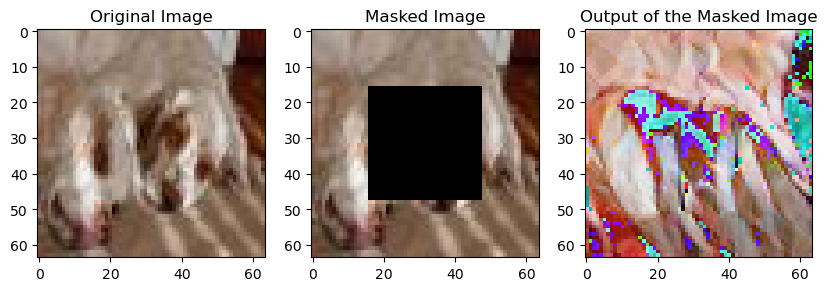

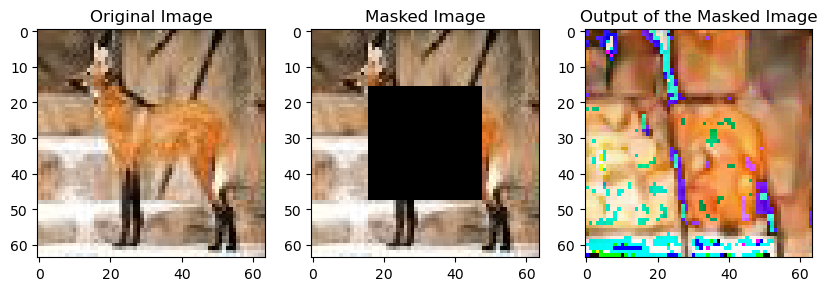

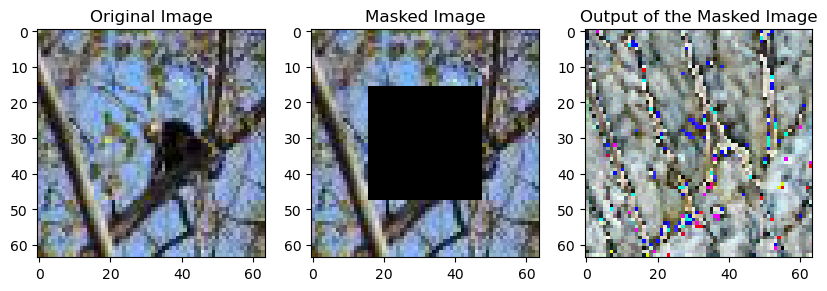

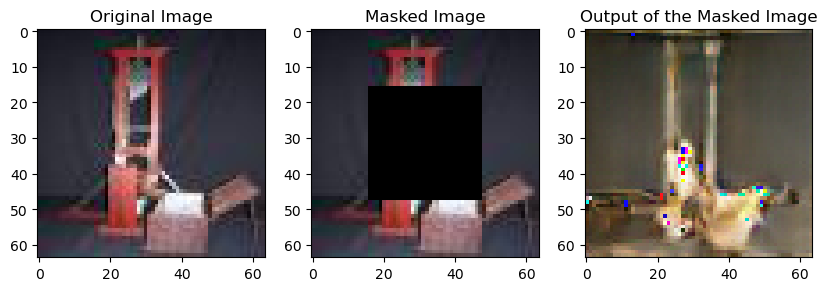

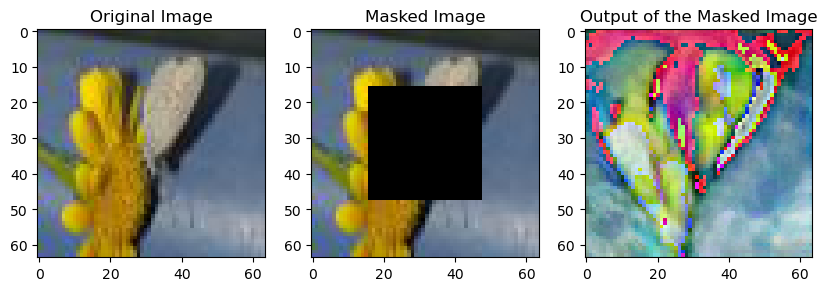

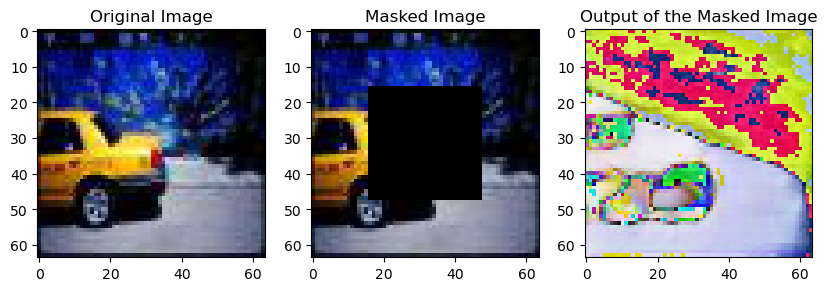

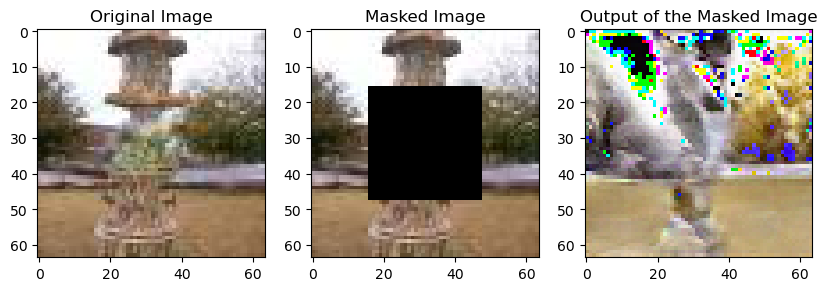

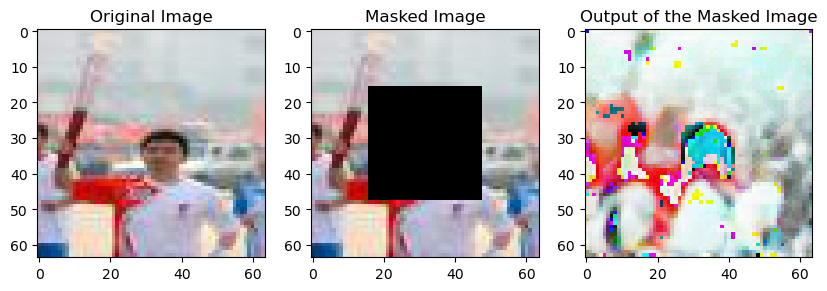

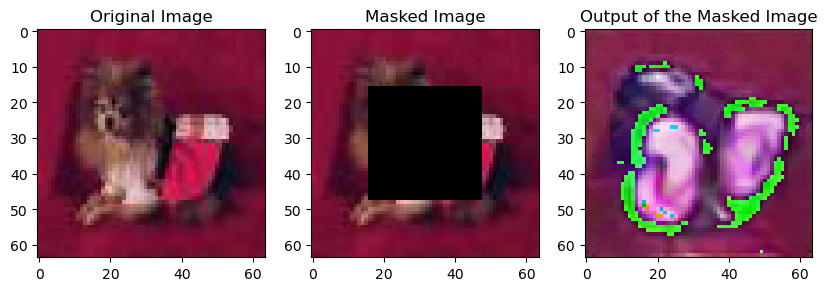

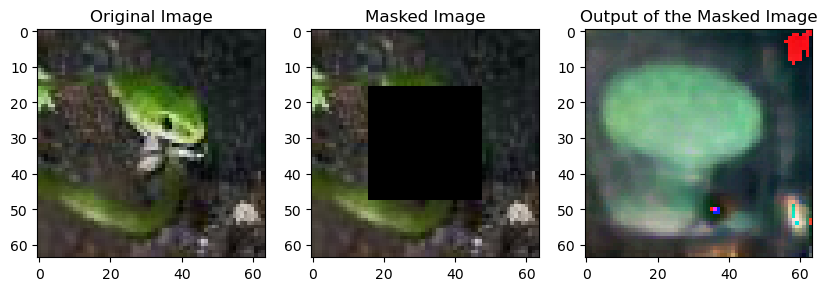

In [6]:
maskGIT.infer_image()

## Quantitative Results

Due to the computational limits, we needed to randomly sample from the Imagenet dataset to create a subset to calculate FID score.

In [7]:
from sampler import sample_dataset
from pytorch_fid import fid_score

paths = ["Output/Images/", "FID_Images/Images/"]
batch_size = 50

# Sample from Imagenet
sample_dataset()

# Calculate FID score
score = fid_score.calculate_fid_given_paths(paths=paths, batch_size=batch_size, device=DEVICE, dims=2048)


1281167
(200000,)


100%|█████████████████████████████████| 200000/200000 [00:32<00:00, 6207.23it/s]


200000 image copied


100%|███████████████████████████████████████| 6879/6879 [09:03<00:00, 12.65it/s]


In [8]:
print(score)

134.56917115110934


We report the FID score as 134.569.

## Challenges

We have faced several difficulties while working on the project.
1) Our main challenge was that our hardware was limited, compared to the authors. Therefore, we switched from the Imagenet dataset to a smaller Imagenet64 dataset.
2) The Bidirectional Transformer part was not detailed in the paper, so we had to read into other related papers in order to have a better understanding of the paper.
3) There were no specifications on how to use the VQGAN on the masked image.
4) The VQGAN itself, without our transformer, produces noisy image, which, we believe, might be another reason behind the noise in the resulting images. 

## References

1. Chang, H., Zhang, H., Jiang, L., Liu, C., &amp; Freeman, W. T. (2022, February 8). Maskgit: Masked generative image transformer. arXiv.org. https://arxiv.org/abs/2202.04200 
2. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., &amp; Polosukhin, I. (2017, December 6). Attention is all you need. arXiv.org. https://arxiv.org/abs/1706.03762 
3. Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., &amp; Houlsby, N. (2021, June 3). An image is worth 16x16 words: Transformers for image recognition at scale. arXiv.org. https://arxiv.org/abs/2010.11929v2 
4. Esser, P., Rombach, R., &amp; Ommer, B. (2021, June 23). Taming transformers for high-resolution image synthesis. arXiv.org. https://arxiv.org/abs/2012.09841 